In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Q1

Write a program for the SVD from scratch using eigen decomposition on the data matrix $X$. Use the top $k$ singular vectors to reconstruct the data matrix
$\hat{X}$. Plot the reconstruction error $||X − \hat{X}||$ for $k = 1,2, \dots$


In [2]:
df = pd.read_csv("../Assignment-1/train.csv", header=None)
X = df.to_numpy(dtype=np.float32)  # datamatrix
X.shape

(60000, 256)

In [3]:
class SVD:
    def __init__(self) -> None:
        pass

    def compute(self, M):
        self.S, self.Vt = np.linalg.eig(M.T @ M)  # change this to use power method
        # self.S, self.Vt = self.eigen(M.T @ M)
        self.Vt = self.Vt.T
        self.S = np.sqrt(self.S)

        ncol = np.argsort(self.S)[::-1]  # arranging in decending order
        self.S = self.S[ncol]
        self.Vt = self.Vt[:, ncol]

        S_inv = np.diag(1 / self.S)  # inverse of diagonal matrix
        self.U = M @ self.Vt.T @ S_inv

    def normalize(self, x):
        fac = abs(x).max()
        x_n = x / x.max()
        return fac, x_n

    def eigen(self, M, max_iter=50):
        A = M.copy()

        eigenvalues = []
        eigenvecs = []
        for j in range(A.shape[0]):
            x = np.ones((A.shape[0],))
            for i in range(max_iter):
                x = A @ x
                lambda_1, x = self.normalize(x)
            eigenvalues.append(lambda_1)
            eigenvecs.append(x)
            A = A - lambda_1 * np.outer(x, x)
        return eigenvalues, np.transpose(eigenvecs)

In [4]:
svd = SVD()
svd.compute(X)

In [5]:
svd.U.shape, svd.S.shape, svd.Vt.shape 

((60000, 256), (256,), (256, 256))

In [6]:
def rec_error(svd, k=256):
    rec = np.zeros((60_000, 256))
    err = []
    for i in tqdm(range(k)):
        outer_prod = np.outer(svd.U[:, i], svd.Vt[i, :])
        rec = rec + outer_prod*svd.S[i]
        err.append(np.linalg.norm(X - rec))
    return range(1, k+1), err

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:14<00:00, 17.33it/s]


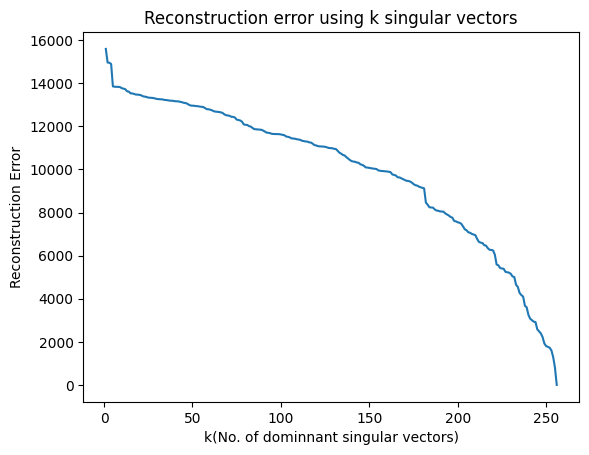

In [7]:
k, err = rec_error(svd, k=256)
plt.plot(k, err)
plt.title("Reconstruction error using k singular vectors")
plt.xlabel("k(No. of dominnant singular vectors)")
plt.ylabel("Reconstruction Error")
plt.show()

# Q2
1. Implement the 8 point algorithm for the image rectification display the two images before and after rectification.
2. Implement the Harris Corner Detection Algorithm plot the corners back to images and display.

In [8]:
def plot_line(coeffs, xlim):
    '''
    Given the coefficients a, b, c of the ax + by + c = 0, 
    plot the line within the given x limits.
    ax + by + c = 0 => y = (-ax - c) / b
    '''
    a, b, c = coeffs
    x = np.linspace(xlim[0], xlim[1], 100)
    y = (a * x + c) / -b
    return x, y

### FUNDAMENTAL MATRIX ###

def show_matching_result(img1, img2, img1_pts, img2_pts):
    '''
    plot the images and their corresponding matching points
    '''
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap="gray")
    for p1, p2 in zip(img1_pts, img2_pts):
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.show()

def compute_fundamental_matrix_normalized(points1, points2):
    '''
    Normalize points by calculating the centroid, subtracting 
    it from the points and scaling the points such that the distance 
    from the origin is sqrt(2)
    
    Parameters
    ------------
    points1, points2 - array with shape [n, 3]
        corresponding points in images represented as 
        homogeneous coordinates
    '''
    # validate points
    assert points1.shape[0] == points2.shape[0], "no. of points don't match"
    
    # compute centroid of points
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    
    # compute the scaling factor
    s1 = np.sqrt(2 / np.mean(np.sum((points1 - c1) ** 2, axis=1)))
    s2 = np.sqrt(2 / np.mean(np.sum((points2 - c2) ** 2, axis=1)))
    
    # compute the normalization matrix for both the points
    T1 = np.array([
        [s1, 0, -s1 * c1[0]],
        [0, s1, -s1 * c1[1]],
        [0, 0 ,1]
    ])
    T2 = np.array([
        [s2, 0, -s2 * c2[0]],
        [0, s2, -s2 * c2[1]],
        [0, 0, 1]
    ])
    
    # normalize the points
    points1_n = T1 @ points1.T
    points2_n = T2 @ points2.T
    
    # compute the normalized fundamental matrix
    F_n = compute_fundamental_matrix(points1_n.T, points2_n.T)
    
    # de-normalize the fundamental
    return T2.T @ F_n @ T1

def compute_fundamental_matrix(points1, points2):
    '''
    Compute the fundamental matrix given the point correspondences
    
    Parameters
    ------------
    points1, points2 - array with shape [n, 3]
        corresponding points in images represented as 
        homogeneous coordinates
    '''
    # validate points
    assert points1.shape[0] == points2.shape[0], "no. of points don't match"
    
    u1 = points1[:, 0]
    v1 = points1[:, 1]
    u2 = points2[:, 0]
    v2 = points2[:, 1]
    one = np.ones_like(u1)
    
    # construct the matrix 
    # A = [u2.u1, u2.v1, u2, v2.u1, v2.v1, v2, u1, v1, 1] for all the points
    # stack columns
    A = np.c_[u1 * u2, v1 * u2, u2, u1 * v2, v1 * v2, v2, u1, v1, one]
    
    # peform svd on A and find the minimum value of |Af|
    U, S, V = np.linalg.svd(A, full_matrices=True)
    f = V[-1, :]
    F = f.reshape(3, 3) # reshape f as a matrix
    
    # constrain F
    # make rank 2 by zeroing out last singular value
    U, S, V = np.linalg.svd(F, full_matrices=True)
    S[-1] = 0 # zero out the last singular value
    F = U @ np.diag(S) @ V # recombine again
    return F

def plot_epipolar_lines(img1, img2, points1, points2, show_epipole=False):
    '''
    Given two images and their corresponding points, compute the fundamental matrix 
    and plot epipole and epipolar lines
    
    Parameters
    ------------
    img1, img2 - array with shape (height, width)
        grayscale images with only two channels
    points1, points2 - array with shape [n, 3]
        corresponding points in images represented as 
        homogeneous coordinates
    show_epipole - boolean
        whether to compute and plot the epipole or not
    '''   
    
    # get image size
    h, w = img1.shape
    n = points1.shape[0]
    # validate points
    if points2.shape[0] != n:
        raise ValueError("No. of points don't match")
    
    # compute the fundamental matrix
    F = compute_fundamental_matrix_normalized(points1, points2)
    
    # configure figure
    nrows = 2
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 8))
    
    # plot image 1
    ax1 = axes[0]
    ax1.set_title("Image 1")
    ax1.imshow(img1, cmap="gray")
    
    # plot image 2
    ax2 = axes[1]
    ax2.set_title("Image 2")
    ax2.imshow(img2, cmap="gray")
    
    # plot epipolar lines
    for i in range(n):
        p1 = points1.T[:, i]
        p2 = points2.T[:, i]
        
        # Epipolar line in the image of camera 1 given the points in the image of camera 2
        coeffs = p2.T @ F
        x, y = plot_line(coeffs, (-1500, w)) # limit hardcoded for this image. please change
        ax1.plot(x, y, color="orange")
        ax1.scatter(*p1.reshape(-1)[:2], color="blue")

        # Epipolar line in the image of camera 2 given the points in the image of camera 1
        coeffs = F @ p1
        x, y = plot_line(coeffs, (0, 2800)) # limit hardcoded for this image. please change
        ax2.plot(x, y, color="orange")
        ax2.scatter(*p2.reshape(-1)[:2], color="blue")
        
    if show_epipole:
        # compute epipole
        e1 = compute_epipole(F)
        e2 = compute_epipole(F.T)
        # plot epipole
        ax1.scatter(*e1.reshape(-1)[:2], color="red")
        ax2.scatter(*e2.reshape(-1)[:2], color="red")
    else:
        # set axes limits
        ax1.set_xlim(0, w)
        ax1.set_ylim(h, 0)
        ax2.set_xlim(0, w)
        ax2.set_ylim(h, 0)

    plt.tight_layout()
    
def compute_epipole(F):
    '''
    Compute epipole using the fundamental matrix.
    pass F.T as argument to compute the other epipole
    '''
    U, S, V = np.linalg.svd(F)
    e = V[-1, :]
    e = e / e[2]
    return e

def compute_matching_homographies(e2, F, im2, points1, points2):
    '''
    Compute the matching homography matrices
    '''
    h, w = im2.shape
    # create the homography matrix H2 that moves the epipole to infinity
    
    # create the translation matrix to shift to the image center
    T = np.array([[1, 0, -w/2], [0, 1, -h/2], [0, 0, 1]])
    e2_p = T @ e2
    e2_p = e2_p / e2_p[2]
    e2x = e2_p[0]
    e2y = e2_p[1]
    # create the rotation matrix to rotate the epipole back to X axis
    if e2x >= 0:
        a = 1
    else:
        a = -1
    R1 = a * e2x / np.sqrt(e2x ** 2 + e2y ** 2)
    R2 = a * e2y / np.sqrt(e2x ** 2 + e2y ** 2)
    R = np.array([[R1, R2, 0], [-R2, R1, 0], [0, 0, 1]])
    e2_p = R @ e2_p
    x = e2_p[0]
    # create matrix to move the epipole to infinity
    G = np.array([[1, 0, 0], [0, 1, 0], [-1/x, 0, 1]])
    # create the overall transformation matrix
    H2 = np.linalg.inv(T) @ G @ R @ T

    # create the corresponding homography matrix for the other image
    e_x = np.array([[0, -e2[2], e2[1]], [e2[2], 0, -e2[0]], [-e2[1], e2[0], 0]])
    M = e_x @ F + e2.reshape(3,1) @ np.array([[1, 1, 1]])
    points1_t = H2 @ M @ points1.T
    points2_t = H2 @ points2.T
    points1_t /= points1_t[2, :]
    points2_t /= points2_t[2, :]
    b = points2_t[0, :]
    a = np.linalg.lstsq(points1_t.T, b, rcond=None)[0]
    H_A = np.array([a, [0, 1, 0], [0, 0, 1]])
    H1 = H_A @ H2 @ M
    return H1, H2

    

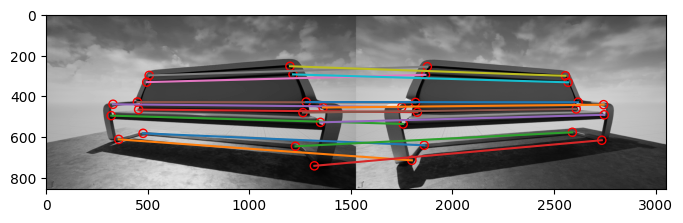

In [9]:
# load images
im1 = cv2.imread("./bench/right.png", cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread("./bench/left.png", cv2.IMREAD_GRAYSCALE)

# load matching points
points1 = np.load("./bench/right_points.npy")
points2 = np.load("./bench/left_points.npy")

show_matching_result(im1, im2, points1, points2)

In [10]:
# compute the normalized fundamental matrix 
F = compute_fundamental_matrix_normalized(points1, points2)

In [11]:
# validate the fundamental matrix equation
p1 = points1.T[:, 0]
p2 = points2.T[:, 0]

np.round(p2.T @ F @ p1)

0.0

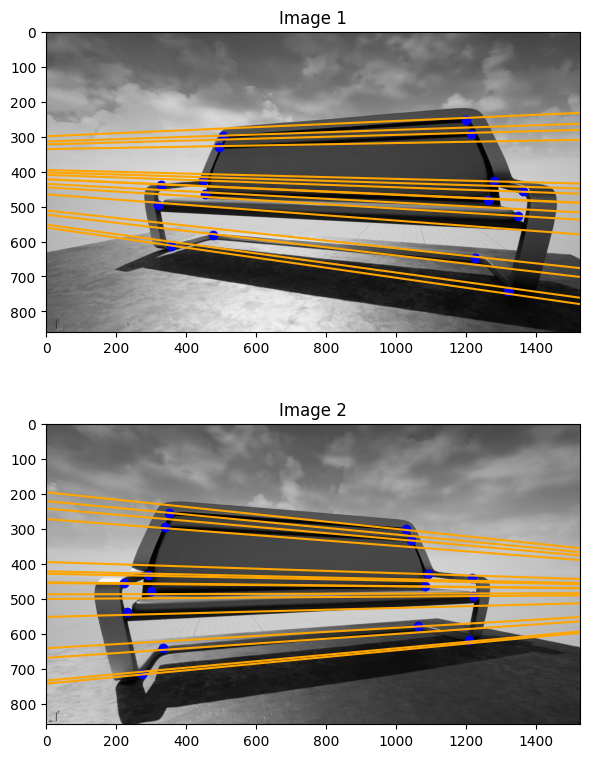

In [12]:
plot_epipolar_lines(im1, im2, points1, points2, show_epipole=False)

In [13]:
e1 = compute_epipole(F)
e2 = compute_epipole(F.T)
# validate fundamental matrix equation for epipoles
np.round(e2.T @ F @ e1)

0.0

In [14]:
H1, H2 = compute_matching_homographies(e2, F, im2, points1, points2)

In [15]:
# Transform points based on the homography matrix
new_points1 = H1 @ points1.T
new_points2 = H2 @ points2.T
new_points1 /= new_points1[2,:]
new_points2 /= new_points2[2,:]
new_points1 = new_points1.T
new_points2 = new_points2.T

# warp images based on the homography matrix
from skimage.transform import warp, ProjectiveTransform
im1_warped = warp(im1, ProjectiveTransform(matrix=np.linalg.inv(H1)))
im2_warped = warp(im2, ProjectiveTransform(matrix=np.linalg.inv(H2)))

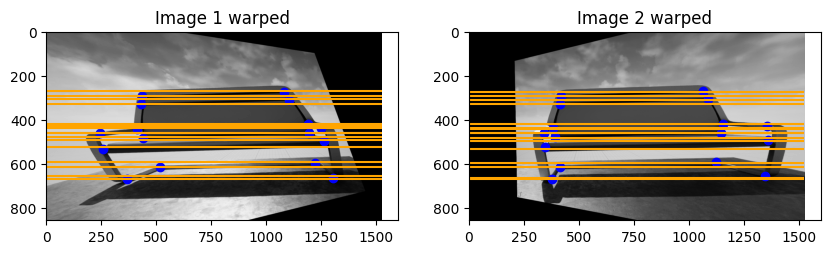

In [16]:
h, w = im1.shape

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))

# plot image 1
ax1 = axes[0]
ax1.set_title("Image 1 warped")
ax1.imshow(im1_warped, cmap="gray")

# plot image 2
ax2 = axes[1]
ax2.set_title("Image 2 warped")
ax2.imshow(im2_warped, cmap="gray")

# plot the epipolar lines and points
n = new_points1.shape[0]
for i in range(n):
    p1 = new_points1[i]
    p2 = new_points2[i]

    ax1.hlines(p2[1], 0, w, color="orange")
    ax1.scatter(*p1[:2], color="blue")

    ax2.hlines(p1[1], 0, w, color="orange")
    ax2.scatter(*p2[:2], color="blue")

In [17]:
# Sobel x-axis kernel
SOBEL_X = np.array(([-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array(([-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array(
    ([1 / 16, 2 / 16, 1 / 16], 
     [2 / 16, 4 / 16, 2 / 16], 
     [1 / 16, 2 / 16, 1 / 16]),
    dtype="float64",
)


def convolve(img, kernel):
    """
    Convolve function for odd dimensions.
    IT CONVOLVES IMAGES
    """
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2

    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode="constant", constant_values=0)
    # Do convolution
    for i in np.arange(pad_height, img_height + pad_height):
        for j in np.arange(pad_width, img_width + pad_width):
            roi = img[
                i - pad_height : i + pad_height + 1, j - pad_width : j + pad_width + 1
            ]
            g[i - pad_height, j - pad_width] = (roi * kernel).sum()

    if g.dtype == np.float64:
        kernel = kernel / 255.0
        kernel = (kernel * 255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = g * 255.0
    return g


def harris(img, threshold=0.6):
    img_cpy = img.copy()  # copying image

    img1_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # grayscaling (0-1)

    dx = convolve(img1_gray, SOBEL_X)  # convolving with sobel filter on X-axis
    dy = convolve(img1_gray, SOBEL_Y)  # convolving with sobel filter on Y-axis
    # square of derivatives
    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxdy = dx * dy  # cross filtering
    # gauss filter for all directions (x,y,cross axis)
    g_dx2 = convolve(dx2, GAUSS)
    g_dy2 = convolve(dy2, GAUSS)
    g_dxdy = convolve(dxdy, GAUSS)
    # Harris Function
    harris = (
        g_dx2 * g_dy2 - np.square(g_dxdy) - 0.12 * np.square(g_dx2 + g_dy2)
    )  # r(harris) = det - k*(trace**2)
    # Normalizing inside (0-1)
    cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)

    # find all points above threshold (nonmax supression line)
    loc = np.where(harris >= threshold)
    # drawing filtered points
    for pt in zip(*loc[::-1]):
        cv2.circle(img_cpy, pt, 3, (0, 0, 255), -1)

    return img_cpy, g_dx2, g_dy2, dx, dy, loc

In [25]:
img = cv2.imread('./0003.jpg', cv2.IMREAD_ANYCOLOR)

corners,g_dx2,g_dy2,dx,dy,loc = harris(img, 0.85)

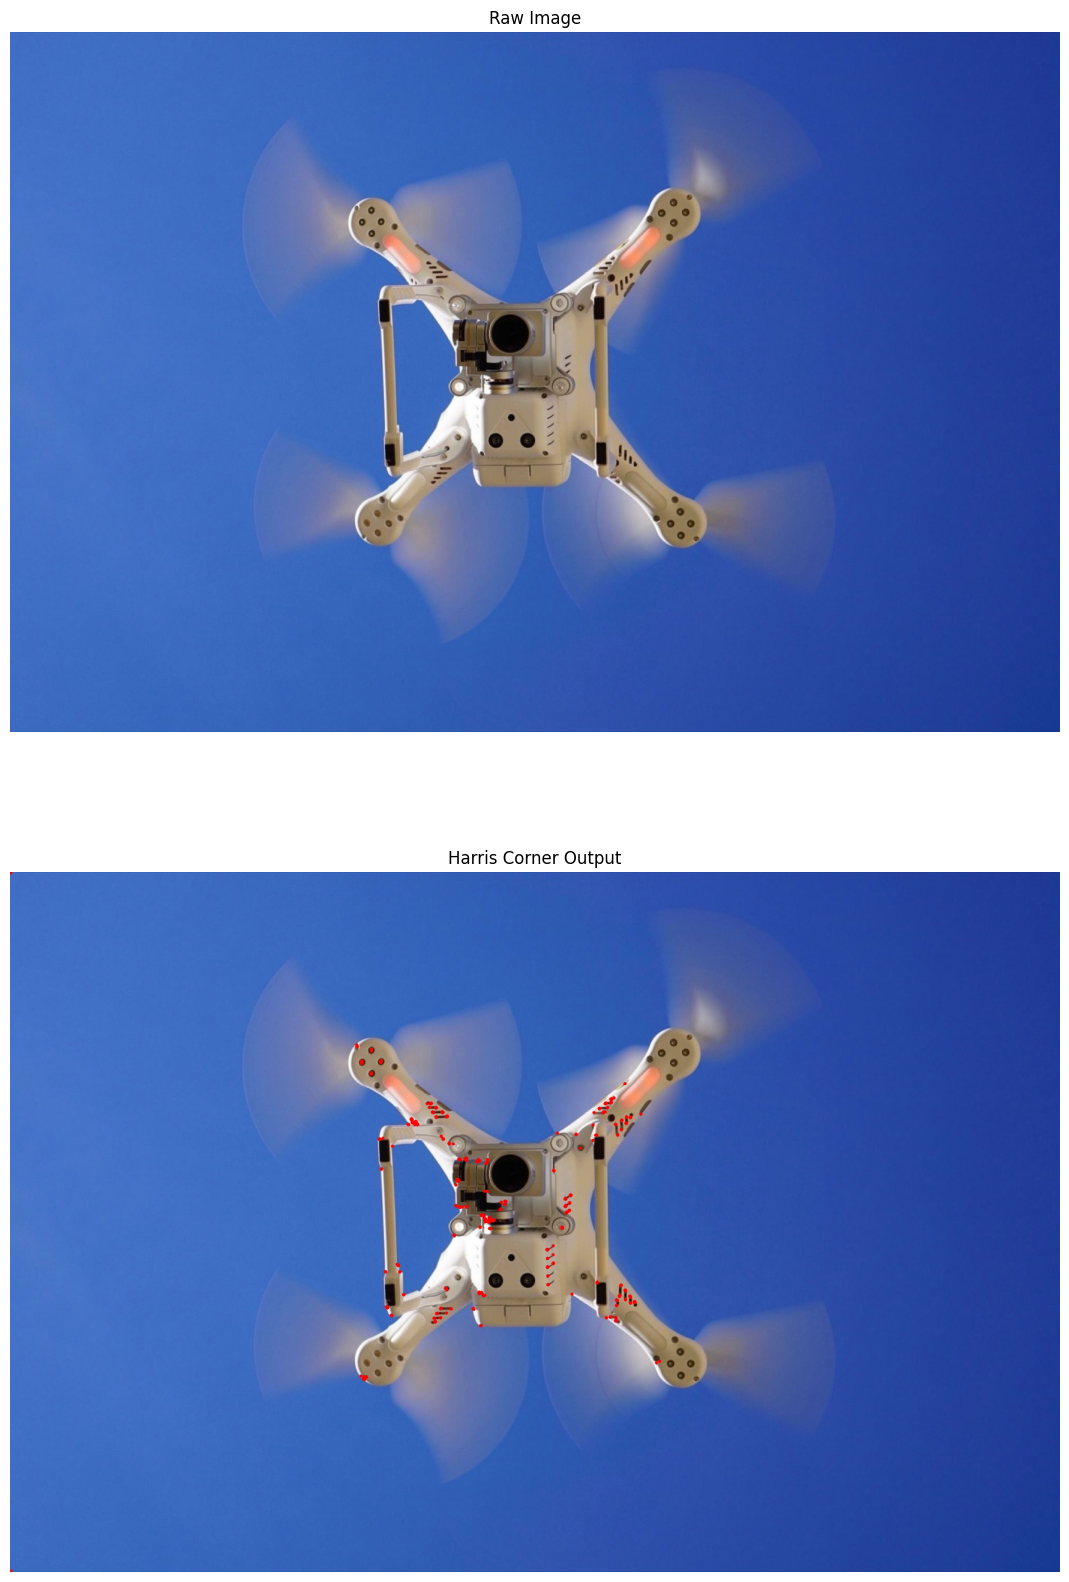

In [30]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1), 
plt.imshow(img[:, :,::-1])
plt.title("Raw Image")
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(corners[:, :, ::-1])
plt.title("Harris Corner Output")
plt.axis('off')
plt.show()